In [1]:
from skimage import io, color, filters, util
from skimage.filters import sobel
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
import matplotlib.pyplot as plt

def image_characteristics(image):
    gray = color.rgb2gray(image)

    # Tekstura: entropia lokalna
    entropy_img = entropy(util.img_as_ubyte(gray), disk(5))
    texture_score = np.mean(entropy_img)

    # Gęstość krawędzi
    edges = sobel(gray)
    edge_density = np.mean(edges > 0.1)

    # Różnorodność kolorów
    color_std = np.mean(np.std(image, axis=(0, 1)))

    # Rozmiar
    h, w = image.shape[:2]
    size_score = (h * w) / 1e5

    return texture_score, edge_density, color_std, size_score


In [2]:
def auto_slic_params(image):
    texture, edge_density, color_std, size_score = image_characteristics(image)

    # Estimate n_segments: base on size and texture/edges
    base_segments = int(100 + 150 * texture + 200 * edge_density + 50 * size_score)
    n_segments = min(max(base_segments, 50), 2000)  # constrain

    # Estimate compactness: high texture → lower compactness
    compactness = 5 + 20 * (1 - texture / np.max([texture, 1]))

    return int(n_segments), float(compactness)


In [3]:
from skimage.segmentation import slic

def prepare_segmented_image(segments, image):
    return color.label2rgb(segments, image, kind='avg')

def show_segmented_image(segments, image):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Oryginalny obraz")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(prepare_segmented_image(segments, image))
    plt.title("Segmentacja (SLIC)")
    plt.axis('off')
    plt.show()

def run_segmentation(img_path):
    image = io.imread(img_path)
    n_segments, compactness = auto_slic_params(image)
    segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=1)
    show_segmented_image(segments, image)
    return segments, image


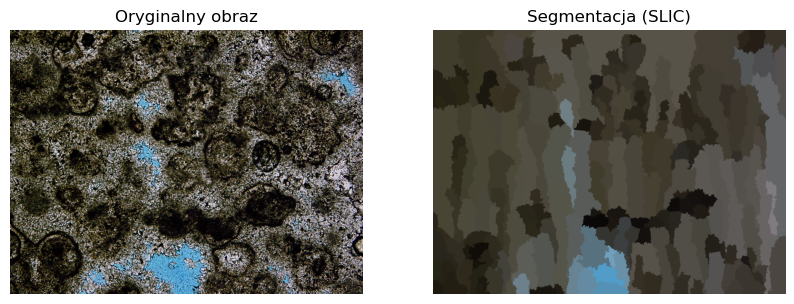

In [4]:
img_path = "./Images01_Porosity_Weglany/b-31-1.bmp"
segments, image = run_segmentation(img_path)

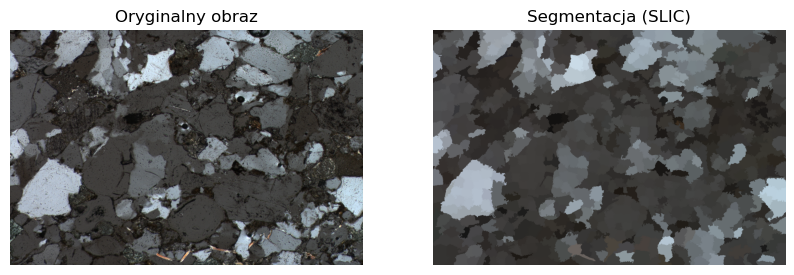

In [5]:
img_path_2 = "./Images02_GrainSize_Mixed/1.tif"
segments, image = run_segmentation(img_path_2)

In [7]:
! pip install transformers

  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.52.4-py3-none-any.whl (10.5 MB)
Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl (2.4 MB)


In [8]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import requests
import torch

# Model i processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
import numpy as np
import pandas as pd
import re
from PIL import Image

def is_statistical_question(q):
    q = q.lower()
    if any(keyword in q for keyword in ['average size', 'mean size']):
        return 'mean'
    elif any(keyword in q for keyword in ['median size']):
        return 'median'
    elif 'percentile' in q:
        return 'percentile'
    elif 'number of segments' in q or 'count' in q:
        return 'count'
    elif 'statistics' in q or 'describe' in q:
        return 'all'
    return None

def get_segment_sizes(segments):
    labels, counts = np.unique(segments, return_counts=True)
    return counts

def answer_statistical_question(segments, question):
    sizes = get_segment_sizes(segments)
    sizes_series = pd.Series(sizes)

    rule = is_statistical_question(question)
    if rule == 'mean':
        return f"Average segment size: {sizes_series.mean():.2f} pixels"
    elif rule == 'median':
        return f"Median segment size: {sizes_series.median():.2f} pixels"
    elif rule == 'percentile':
        match = re.search(r'(\d+)', question)
        if match:
            p = int(match.group(1))
            perc_value = sizes_series.quantile(p / 100)
            return f" {p}th percentile of segment size: {perc_value:.2f} pixels"
        else:
            return "⚠️ Please specify a percentile, e.g., '90th percentile'."
    elif rule == 'count':
        return f"Number of segments: {len(sizes)}"
    elif rule == 'all':
        return f"Segment size statistics:\n{sizes_series.describe()}"
    else:
        return None

# Main function
def ask_question_about_image():
    image_path = input("Enter path to image: ")

    try:
        segments, image = run_segmentation(image_path)
    except Exception as e:
        print(f"Segmentation error: {e}")
        return

    try:
        pil_image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    question = input("Enter your question (or 'quit' to exit): ")

    while question is not None and question.lower() not in ['quit', 'q', 'exit']:
        if is_statistical_question(question):
            answer = answer_statistical_question(segments, question)
            print(question)
            print(answer)
        else:
            # Visual question answered by BLIP model
            inputs = processor(pil_image, question, return_tensors="pt")
            out = model.generate(**inputs)
            answer = processor.decode(out[0], skip_special_tokens=True)
            print(question)
            print(f"Model answer: {answer}")

        question = input("Enter another question (or 'quit' to exit): ")




./Images01_Porosity_Weglany/b-31-4.bmp

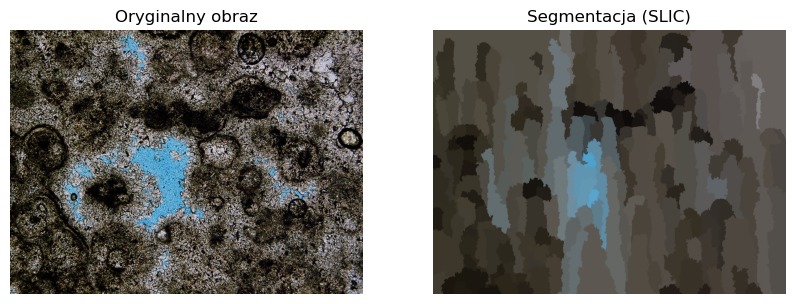

what is dominant color
Model answer: blue
what is the second most important color
Model answer: blue
is this image colorful
Model answer: yes
is this high or small granularity
Model answer: high
what this image shows
Model answer: blue speckled floor
can this image be rock in the microscope
Model answer: yes
87th percentile
 87th percentile of segment size: 7528.44 pixels
stats
Model answer: 0
statistics
Segment size statistics:
count      180.000000
mean      4369.066667
std       4886.966731
min        538.000000
25%       1583.000000
50%       2981.500000
75%       5457.750000
max      40399.000000
dtype: float64
min size
Model answer: 1
mean size
Average segment size: 4369.07 pixels
what is the count of segments
Number of segments: 180
what is 67th percentile for size
 67th percentile of segment size: 4197.74 pixels


In [10]:
ask_question_about_image()